In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#**Problem Formulation**

**Define the problem** * Based on the graph data, the challenge is a binary classification.

* The assignment is to use the chemical structure of a drug to forecast its anticancer efficacy.

* The chemical compound is assigned a label of 0 or 1 depending on whether it is positive or negative against lung cancer cells.


**Define the data input**

* Nodes: Each one has tokenized chemical compound atoms within it.

* Edges: How one node relates to other nodes.

* Node2graph: The segmented ids information contained in the input tensor used for the segmented mean.


**Define the output data**

* If the compound is positive or otherwise negative for non-small cell lung cancer, the probability is compound-related.


**What data mining function is required?**

Data Tokenizer.

Data Padding.

Reshape.

Data resample.

Data Concat.

Embedding and Dense layers.


**What could be the challenges?**

* The data needs to be tokenized and padded because it contains characters.

* The positive class is overly tiny, and the statistics are likewise unbalanced. To get a good match, this data needs to be resampled.


**What is the impact?**

Determine whether a substance is positive for non-small cell lung cancer and predict anticancer activity.


**What is an ideal solution?**

 using "message_calculation_class" ='GNN_FiLM'with Balanced Data


## Questions

#### 🌈 **Based on the provided template, describe the format of the input file (sdf file).**

A file format that holds details about a molecule's chemical makeup is called a structure data file (SDF). This file format contains information on the locations of individual atoms within a chemical compound as well as the relationships that exist between them. The delimiter (four dollar signs) divides the several molecules in the file.

A header with the compound's name or title appears at the beginning of every molecule. Details about the number of atoms, the version number, and connections are included in other sections of the file. While the Bond block explains the bonding structure, the Atom block gives information about the constituent elements of the molecule.
<br><br>

#### 🌈 **What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

In this network, the input tensors are:

1. **Data:** The tokenized nodes of the chemical compound are contained in this tensor, which has been padded using the pad_sequence technique. Each batch's data is organized as [batch_size*max_len_nodes], where max_len_nodes is the length of tokenized nodes following padding, and batch_size is the number of samples in the batch.

2. **edge:** Information regarding the bonds between the atoms in the chemical molecule is carried by this tensor. An edge has the form [sum_of_all_edges,2], where sum_of_all_edges is the total number of edges in all batch samples.

3. **node2graph:** This tensor is used for segmented mean and provides data about segmented ids. Every batch's node2graph has the following shape: [batch_size*max_len_nodes], where max_len_nodes is the length of tokenized nodes following padding, and batch_size is the number of samples in the batch.
<br><br>

#### 🌈 **For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

The output of the graph neural network following aggregation for every hidden layer is stored in the gnn_out tensor. It represents the combined output of the model and is shaped by the number of hidden layers and the dimension of the input data (node) vector.

By obtaining the segmented mean of the gnn_out tensor based on the segmented ids, one can obtain the average tensor. This procedure produces a tensor of shape [batch_size, hidden_layer] by essentially calculating the mean value of the gnn_out tensor for each sample in the batch. Through this procedure, the model is able to gather and compress the pertinent data for every sample.
<br><br>

#### 🌈 **What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

tf.reduce_mean and segment_mean are two TensorFlow functions used for computing the mean of a tensor.

* **tf.reduce_mean** calculates the mean over all dimensions of the tensor.
* **segment_mean** calculates the mean based on segments defined by a segmentation tensor.


The model's final output, the **pred tensor**, tells us how likely it is that a certain chemical compound will be effective against cancer cells. Its shape is [batch_size, 1], which means that the pred tensor generates a single value representing the likelihood of the compound's action against cancer cells for every sample in the batch.

Put otherwise, the pred tensor offers an indicator of how likely it is that a specific chemical will be useful in the fight against cancer. This data can be used to direct the development of novel medicines or to select interesting candidates for additional testing.
<br><br>

#### 🌈 **What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

The description states that the standard template for the GCN (graph convolutional network) implementation employs four layers. Relational graph convolution, or rgcn, is the default message passing technique in this implementation. It helps to take into account the complexity of the graph structure and enhances the performance of the model.

The model's performance can be further improved by using additional GCN layers, which allow the graph to contain more intricate interactions. **Five** distinct GCN mechanisms (RGAT, GGNN, gnn_edge_mlp, RGCN, and RGIN) were employed in this template.

In [50]:
import math
import random
import networkx as nx
import tensorflow as tf
from matplotlib import cm
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from pandas.core.frame import DataFrame
from tensorflow.math import segment_mean
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.ops.gen_math_ops import segment_max
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [4]:
!unzip -q /content/cisc873-dm-w24-a6.zip

In [51]:
# File path to your SDF file
file_path ='/content/train.sdf'

# Read the first 5 lines of the SDF file
with open(file_path, "r") as file:
    sdf_content = file.readlines()[:140]

# Display the first 5 lines
for line in sdf_content:
    print(line)



495443





 25 28  0  0  0  0              1 V2000

    0.0000    0.0000    0.0000 S   0  0  0  0  0  0

    0.0000    0.0000    0.0000 O   0  0  0  0  0  0

    0.0000    0.0000    0.0000 O   0  0  0  0  0  0

    0.0000    0.0000    0.0000 O   0  5  0  0  0  0

    0.0000    0.0000    0.0000 O   0  0  0  0  0  0

    0.0000    0.0000    0.0000 N   0  0  0  0  0  0

    0.0000    0.0000    0.0000 N   0  0  0  0  0  0

    0.0000    0.0000    0.0000 N   0  3  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  0  0  0

    0.0000    0.0000    0.0000 C   0  0  0  

In [53]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')


# function to split the data into nodes,edges and labels
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1,
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label #then returning nodes, links and label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] #parse_sample for each molecul

In [54]:
#read train data
train = read_sdf('/content/train.sdf')
#read test data
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [55]:
training_set, validation_set = train_test_split(train, test_size=0.15,random_state=35)

In [56]:
#sample of train set
print(training_set[1])

(['P', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  7],
       [ 1, 11],
       [ 2, 12],
       [ 4,  9],
       [ 4, 13],
       [ 5,  9],
       [ 5, 14],
       [ 6, 10],
       [ 7,  8],
       [ 7, 10],
       [ 8,  9],
       [11, 15],
       [12, 16],
       [13, 14]]), 0)


In [57]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [58]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]

    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:

    for e in edges:
        G.add_edge(e[0], e[1])

    nx.draw_networkx(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()

    return G

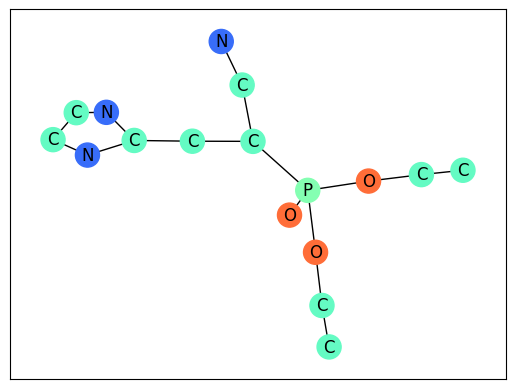

In [59]:
plt.clf()
visualize(training_set[1])

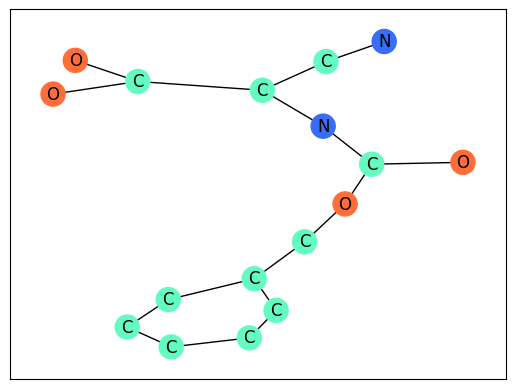

In [60]:
plt.clf()
visualize(training_set[5])

# Preprocessing

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
#vocabulary size
max_vocab = 500
max_len = 100

all_nodes = [s[0] for s in training_set]

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

import random
random.seed(5)

def prepare_single_batch(samples):

    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]

    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]

    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)


    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [64]:
len([8, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

39

In [65]:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[8 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
edges
[[  0   4]
 [  0   5]
 [  0   6]
 [  0   7]
 [  1   8]
 [  2  15]
 [  2  25]
 [  3  15]
 [  4   9]
 [  4  12]
 [  5  10]
 [  5  13]
 [  6  11]
 [  6  14]
 [  7   8]
 [  8  15]
 [  9  16]
 [ 10  17]
 [ 11  18]
 [ 12  19]
 [ 13  20]
 [ 14  21]
 [ 16  22]
 [ 17  23]
 [ 18  24]
 [ 19  22]
 [ 20  23]
 [ 21  24]
 [ 25  26]
 [ 38  46]
 [ 38  50]
 [ 39  47]
 [ 40  51]
 [ 41  53]
 [ 42  55]
 [ 43  57]
 [ 44  46]
 [ 44  47]
 [ 44  49]
 [ 45  47]
 [ 45  53]
 [ 46  52]
 [ 48  49]
 [ 48  53]
 [ 48  54]
 [ 50  51]
 [ 50  55]
 [ 51  52]
 [ 54  56]
 [ 56  57]
 [ 57  58]
 [ 58  59]
 [ 58  60]
 [ 59  62]
 [ 60  63]
 [ 61  62]
 [ 61  63]
 [ 61  64]
 [ 76  86]
 [ 77  87]
 [ 78  89]
 [ 79  9

# Trial_1

we use default layers of gnn

we will use message_calculation_class : "GGNN"

we define gnn input as a variable to define all input layers

In [66]:
tokenizer.num_words

500

In [67]:
# Define a tensor with values and segment IDs
values = tf.constant([1, 2, 3, 4, 5, 6])
segment_ids = tf.constant([0, 0, 1, 1,2 , 2])

# Compute the segment mean
segment_means = tf.math.segment_mean(data=values, segment_ids=segment_ids)

# Print the result
print("Segment Means:", segment_means.numpy())

Segment Means: [1 3 5]


In [68]:
tokenizer.num_words

500

In [69]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)

node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)


embeded = Embedding(tokenizer.num_words, 60)(data)

num_graph = tf.reduce_max(node2graph)+1

print(num_graph)


KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.__operators__.add_5/AddV2:0', description="created by layer 'tf.__operators__.add_5'")


In [70]:
!pip install tf2_gnn

In [71]:
!pip show tf2_gnn

Name: tf2-gnn
Version: 2.14.0
Summary: TensorFlow 2.0 implementation of Graph Neural Networks.
Home-page: https://github.com/microsoft/tf2-gnn/
Author: Marc Brockschmidt
Author-email: mabrocks@microsoft.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: dpu-utils, h5py, numpy, packaging, tensorflow
Required-by: 


In [72]:
from tf2_gnn.layers.gnn import GNN, GNNInput

In [73]:
gnn_input = GNNInput(
    node_features=embeded,            # Node features for each node in the graph. This could be embeddings or other representations of node attributes.
    adjacency_lists=(edge,),         # List of adjacency lists representing the graph structure. Each element corresponds to an edge and contains the indices of the connected nodes.
    node_to_graph_map=node2graph,     # Mapping of node indices to the graph they belong to. This is useful when dealing with multiple graphs in the same dataset.
    num_graphs=num_graph,            # Number of graphs in the dataset. This parameter specifies the total number of graphs the input represents.
)


# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"]= "GGNN"


gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input )

print('gnn_out', gnn_out)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")


In [74]:
avg = segment_mean( data=gnn_out,  segment_ids=node2graph )#[12 10 30 6]
print('mean:', avg) # the number will be equal the batch size

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_5 (TFOp  ()               

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [35]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history1 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_1.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 49s 31ms/step - loss: 0.1983 - auc: 0.6223 - val_loss: 0.1686 - val_auc: 0.6897
Epoch 2/10
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1897 - auc: 0.6500 - val_loss: 0.1709 - val_auc: 0.6790
Epoch 3/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.1849 - auc: 0.6813 - val_loss: 0.1653 - val_auc: 0.6998
Epoch 4/10
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1803 - auc: 0.7056 - val_loss: 0.1642 - val_auc: 0.7060
Epoch 5/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.1773 - auc: 0.7267 - val_loss: 0.1688 - val_auc: 0.7376
Epoch 6/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1733 - auc: 0.7407 - val_loss: 0.1593 - val_auc: 0.7648
Epoch 7/10
1330/1330 [==============================] - 39s 30ms/step - loss: 0.1723 - auc: 0.7463 - val_loss: 0.1557 - val_auc: 0.7530
Epoch 8/10
1330/1330 [==========================

# Trial 2

The RGAT mechanism

A specific kind of neural network intended to function with graph-structured data is called the relational graph attention network. Three essential parts make up the RGAT mechanism: input, graph attention, and output.

The input component receives a graph represented as a set of nodes and edges, which are subsequently converted by shared neural network layers into initial node embeddings and edge features. The graph attention component receives these initial embeddings and features and uses attention processes to determine the relative relevance of various nodes and edges in the graph structure. Iteratively applying this attention process across several layers results in updated node embeddings and edge features for each layer, which are based on attention weights from the preceding layer.

The final predictions are then produced by the output component using the modified node embeddings. Depending on the particular task at hand, this output may take several forms, including edge prediction, node classification, or graph classification.

In [36]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['num_layers'] = 32
params["message_passing"] = "RGAT"
params["initial_node_representation_activation"] = "relu"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
             

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [38]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history2 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_2.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 292s 192ms/step - loss: 0.2488 - auc: 0.4187 - val_loss: 0.1876 - val_auc: 0.4971
Epoch 2/10
1330/1330 [==============================] - 230s 173ms/step - loss: 0.2057 - auc: 0.5276 - val_loss: 0.1860 - val_auc: 0.5005
Epoch 3/10
1330/1330 [==============================] - 256s 193ms/step - loss: 0.1995 - auc: 0.5766 - val_loss: 0.1848 - val_auc: 0.6433
Epoch 4/10
1330/1330 [==============================] - 264s 199ms/step - loss: 0.1964 - auc: 0.6096 - val_loss: 0.1710 - val_auc: 0.6547
Epoch 5/10
1330/1330 [==============================] - 210s 158ms/step - loss: 0.1932 - auc: 0.6382 - val_loss: 0.1756 - val_auc: 0.6665
Epoch 6/10
1330/1330 [==============================] - 220s 165ms/step - loss: 0.1949 - auc: 0.6246 - val_loss: 0.1758 - val_auc: 0.6472
Epoch 7/10
1330/1330 [==============================] - 208s 157ms/step - loss: 0.1938 - auc: 0.6201 - val_loss: 0.1704 - val_auc: 0.6435
Epoch 8/10
1330/1330 [============

# Trial 3

GNN with Edge MLPs Mechanism

Every edge in the graph has a unique MLP assigned to it by the Edge MLPs mechanism. These MLPs generate an output that represents the converted edge information using the features of the edge and the connected nodes as inputs. In the following message passing steps, the outputs from the Edge MLPs are coupled with the node representations, allowing the GNN to integrate edge-specific data into the node-level calculations.

GNNs are able to capture more intricate interactions and dependencies between nodes through their connecting edges by integrating Edge MLPs.


In [39]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 150)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

fc1 = Dense(8,activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None,)]                    0         []                            
             

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [41]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history3 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_3.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 42s 29ms/step - loss: 0.2279 - auc: 0.5196 - val_loss: 0.2154 - val_auc: 0.5919
Epoch 2/10
1330/1330 [==============================] - 42s 32ms/step - loss: 0.1891 - auc: 0.6599 - val_loss: 0.1720 - val_auc: 0.6610
Epoch 3/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1818 - auc: 0.7055 - val_loss: 0.1682 - val_auc: 0.6716
Epoch 4/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1786 - auc: 0.7226 - val_loss: 0.1705 - val_auc: 0.7509
Epoch 5/10
1330/1330 [==============================] - 42s 31ms/step - loss: 0.1768 - auc: 0.7369 - val_loss: 0.1594 - val_auc: 0.7372
Epoch 6/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1738 - auc: 0.7502 - val_loss: 0.1734 - val_auc: 0.6809
Epoch 7/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1720 - auc: 0.7571 - val_loss: 0.1490 - val_auc: 0.7593
Epoch 8/10
1330/1330 [==========================

# Trial 4

 improve the performance of the GCN model by incorporating additional modifications to the model and the training process.

In [42]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["message_calculation_class"]= "GGNN" # Gated Graph Neural Networks
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

fc1 = Dense(8,activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

model_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None,)]                    0         []                            
             

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [44]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history4 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_4.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 45s 31ms/step - loss: 0.1689 - auc: 0.7782 - val_loss: 0.1623 - val_auc: 0.7383
Epoch 2/10
1330/1330 [==============================] - 38s 28ms/step - loss: 0.1689 - auc: 0.7740 - val_loss: 0.1604 - val_auc: 0.7390
Epoch 3/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1677 - auc: 0.7803 - val_loss: 0.1493 - val_auc: 0.7672
Epoch 4/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.1647 - auc: 0.7910 - val_loss: 0.1555 - val_auc: 0.7858
Epoch 5/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.1648 - auc: 0.7942 - val_loss: 0.1549 - val_auc: 0.7820
Epoch 6/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1643 - auc: 0.7962 - val_loss: 0.1606 - val_auc: 0.7496
Epoch 7/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.1651 - auc: 0.7965 - val_loss: 0.1512 - val_auc: 0.7821
Epoch 8/10
1330/1330 [==========================

# Trial 5

RGIN

An architecture for a graph neural network called the Relational Graph Isomorphism Network focuses on obtaining relational information between nodes in a graph. RGIN incorporates a relational graph isomorphism module to handle the problem of differentiating between nodes with identical structural attributes.
RGIN can learn node representations that are invariant to isomorphic transformations with the help of the relational graph isomorphism module. RGIN is able to distinguish nodes according to their distinct connections with neighboring nodes by comparing their structural patterns within a small neighborhood.


In [75]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 150)(data)

In [76]:
num_graph = tf.reduce_max(node2graph)+1
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Isomorphism Networks
params["message_calculation_class"] = 'RGIN'
# params["num_edge_MLP_hidden_layers"] = 32 ##
params["num_aggr_MLP_hidden_layers"] = 6
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64]

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg)
#output shape: [batch_size,1]
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

#building model
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None,)]                    0         []   

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [78]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history5 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_5.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 97s 63ms/step - loss: 0.2281 - auc: 0.5559 - val_loss: 0.1776 - val_auc: 0.5920
Epoch 2/10
1330/1330 [==============================] - 78s 59ms/step - loss: 0.2000 - auc: 0.6203 - val_loss: 0.1694 - val_auc: 0.6813
Epoch 3/10
1330/1330 [==============================] - 71s 54ms/step - loss: 0.1974 - auc: 0.6304 - val_loss: 0.1709 - val_auc: 0.6808
Epoch 4/10
1330/1330 [==============================] - 76s 57ms/step - loss: 0.1947 - auc: 0.6260 - val_loss: 0.1763 - val_auc: 0.6156
Epoch 5/10
1330/1330 [==============================] - 72s 54ms/step - loss: 0.1941 - auc: 0.6273 - val_loss: 0.1656 - val_auc: 0.7009
Epoch 6/10
1330/1330 [==============================] - 70s 52ms/step - loss: 0.1890 - auc: 0.6602 - val_loss: 0.1839 - val_auc: 0.6624
Epoch 7/10
1330/1330 [==============================] - 74s 56ms/step - loss: 0.1873 - auc: 0.6763 - val_loss: 0.1718 - val_auc: 0.6637
Epoch 8/10
1330/1330 [==========================

# Trial 6

Upsampling will be applied here to balance data.

In [89]:
training_set = read_sdf('/content/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [86]:
from sklearn.utils import resample
#read the training data as a dataframe
df = pd.DataFrame(training_set,columns=['Nodes','Edges','Labels'])
df_majority = df[df['Labels']==0]  #data with majority class
df_minority = df[df['Labels']==1]  #data with maniority class

print('Shape of Unbalanced Data before Upsampling:')
print(df_majority.shape)
print(df_minority .shape)
print('\n')

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                  # sample with replacement
                                 replace=True,
                                 # to match majority class
                                 n_samples=len(df_majority),
                                  # reproducible results
                                 random_state=42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print('New class counts after Upsampling:')
df_upsampled['Labels'].value_counts()

Shape of Unbalanced Data before Upsampling:
(23806, 3)
(1218, 3)


New class counts after Upsampling:


Labels
0    23806
1    23806
Name: count, dtype: int64

In [87]:
training_set= df_upsampled.to_numpy()

<Axes: xlabel='0'>

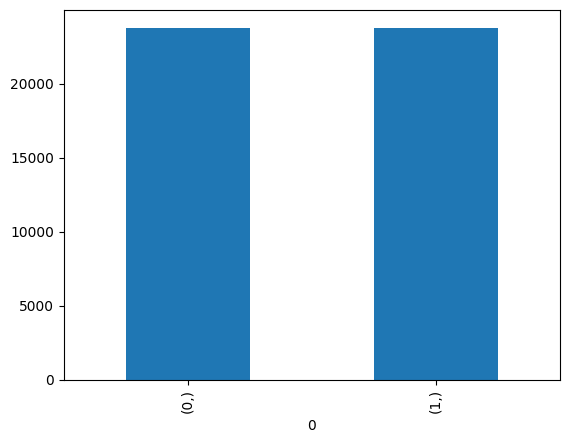

In [88]:
DataFrame(np.array(training_set)[:,-1]).value_counts().plot(kind='bar')

In [95]:
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [97]:
len(training_set), len(testing_set)

(21270, 12326)

In [98]:
max_vocab = 500
# max_len = 100 # better approach: iterate over all nodes in each sample and return the max length of nodes


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [99]:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   4]
 [  0  10]
 [  1   6]
 [  2  10]
 [  3   4]
 [  3   6]
 [  3   7]
 [  4   5]
 [  5   8]
 [  5  11]
 [  6   8]
 [  7   9]
 [  7  12]
 [  8  13]
 [  9  10]
 [  9  14]
 [ 11  15]
 [ 12  17]
 [ 13  16]
 [ 14  18]
 [ 15  16]
 [ 17  18]
 [ 36  54]
 [ 37  57]
 [ 38  58]
 [ 39  62]
 [ 39  71]
 [ 40  62]
 [ 41  48]
 [ 42  48]
 [ 43  67]
 [ 44  51]
 [ 44  53]
 [ 45  54]
 [ 45  56]
 [ 46  49]
 [ 46  55]
 [ 47  58]
 [ 47  64]
 [ 48  61]
 [ 50  67]
 [ 51  52]
 [ 51  54]
 [ 52  55]
 [ 52  57]
 [ 53  56]
 [ 53  60]
 [ 55  58]
 [ 56  59]
 [ 57  62]
 [ 59  61]
 [ 60  63]
 [ 61  63]
 [ 64  65]
 [ 64  66]
 [ 65  67]
 [ 65  68]
 [ 66  69]
 [ 68  70]
 [ 69  70]
 [ 72  78]
 [ 72  86]
 [ 73  80]
 [ 

In [100]:
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"]= "GGNN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
max = segment_max(
    data=gnn_out,
    segment_ids=node2graph
)
print('max:', max)

pred = Dense(1, activation='sigmoid')(max)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
max: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_max/SegmentMax:0', description="created by layer 'tf.math.segment_max'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_13/Sigmoid:0', description="created by layer 'dense_13'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None,)]                    0         []           

In [101]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [102]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history6 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_6.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 46s 30ms/step - loss: 0.2003 - auc: 0.5665 - val_loss: 0.1824 - val_auc: 0.6792
Epoch 2/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1862 - auc: 0.6604 - val_loss: 0.1779 - val_auc: 0.7062
Epoch 3/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1815 - auc: 0.6857 - val_loss: 0.1844 - val_auc: 0.7084
Epoch 4/10
1330/1330 [==============================] - 42s 32ms/step - loss: 0.1790 - auc: 0.7015 - val_loss: 0.1808 - val_auc: 0.7219
Epoch 5/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1780 - auc: 0.7105 - val_loss: 0.1818 - val_auc: 0.7259
Epoch 6/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1765 - auc: 0.7240 - val_loss: 0.1850 - val_auc: 0.6764
Epoch 7/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1804 - auc: 0.6971 - val_loss: 0.1746 - val_auc: 0.7210
Epoch 8/10
1330/1330 [==========================

# Trial 7

 improve the performance of the GCN model by incorporating additional modifications (shown below) to the model and the training process.

determining which molecular features are most pertinent to include in the model by applying a more powerful feature selection method, like genetic programming or Bayesian optimization. This strategy might assist the model in concentrating on the most crucial elements and enhance its capacity to forecast the chemicals' toxicity.



In [83]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 150)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

fc1 = Dense(8,activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_12/Sigmoid:0', description="created by layer 'dense_12'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None,)]                    0         []                            
           

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [85]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history7 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_7.csv')
print("Finish This trial")

Epoch 1/10
1564/1564 [==============================] - 55s 32ms/step - loss: 0.2055 - auc: 0.5904 - val_loss: 0.1931 - val_auc: 0.6800
Epoch 2/10
1564/1564 [==============================] - 51s 33ms/step - loss: 0.1854 - auc: 0.6681 - val_loss: 0.1680 - val_auc: 0.7147
Epoch 3/10
1564/1564 [==============================] - 49s 31ms/step - loss: 0.1785 - auc: 0.7092 - val_loss: 0.1576 - val_auc: 0.7556
Epoch 4/10
1564/1564 [==============================] - 52s 33ms/step - loss: 0.1747 - auc: 0.7317 - val_loss: 0.1637 - val_auc: 0.7261
Epoch 5/10
1564/1564 [==============================] - 50s 32ms/step - loss: 0.1740 - auc: 0.7351 - val_loss: 0.1623 - val_auc: 0.7447
Epoch 6/10
1564/1564 [==============================] - 50s 32ms/step - loss: 0.1736 - auc: 0.7383 - val_loss: 0.1568 - val_auc: 0.7456
Epoch 7/10
1564/1564 [==============================] - 54s 35ms/step - loss: 0.1697 - auc: 0.7564 - val_loss: 0.1627 - val_auc: 0.7694
Epoch 8/10
1564/1564 [==========================

# Trial 8

 improve the performance of the GCN model by incorporating additional modifications to the model and the training process.

integrating transfer learning into the model, which entails fine-tuning the model on the target dataset after pre-training it on a bigger dataset containing a comparable task. By using this method, the model could be able to acquire more universal characteristics and connections that it can use to enhance its performance on the intended job.



In [103]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["message_calculation_class"]= "GGNN" # Gated Graph Neural Networks
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

fc1 = Dense(8,activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_15/Sigmoid:0', description="created by layer 'dense_15'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None,)]                    0         []                            
           

In [104]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [105]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history8 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_8.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 45s 30ms/step - loss: 0.1991 - auc: 0.6080 - val_loss: 0.1802 - val_auc: 0.6595
Epoch 2/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.1857 - auc: 0.6575 - val_loss: 0.1758 - val_auc: 0.7021
Epoch 3/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1825 - auc: 0.6712 - val_loss: 0.1709 - val_auc: 0.7037
Epoch 4/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1801 - auc: 0.6786 - val_loss: 0.1711 - val_auc: 0.7076
Epoch 5/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.1786 - auc: 0.6818 - val_loss: 0.1748 - val_auc: 0.7246
Epoch 6/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1791 - auc: 0.6834 - val_loss: 0.1725 - val_auc: 0.7150
Epoch 7/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.1795 - auc: 0.6812 - val_loss: 0.1800 - val_auc: 0.6876
Epoch 8/10
1330/1330 [==========================

# Trial 9

RGCN Mechanism

One particular kind of neural network intended for use with graph-structured data is the Relation Graph Convolutional Network (RGCN) mechanism. It consists of the following components: output, relation-specific weight sharing, and input.

 a common neural network layer in the input component converts a graph of nodes and edges into initial node embeddings. The model is thus able to capture distinct properties and relationships associated with each type of edge thanks to the relation-specific weight sharing component, which assigns a distinct set of weights to each edge type in the graph.

predictions are produced by the output component using the revised node embeddings. The use of relation-specific weight sharing to capture the unique characteristics and interactions associated with each type of edge in the graph is the main novelty of the RGCN method. As a result, the model can better represent intricate connections and relationships between nodes, producing predictions that are more accurate.

In [106]:
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embedded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph) + 1

gnn_input = GNNInput(
    node_features=embedded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["message_calculation_class"]= "RGCN" # Relation Graph Convolutional Networks
params["dense_intermediate_layer_activation"] = 'tanh'
params["num_layers"] = 4
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
print(gnn_out)
max = segment_max(
    data=gnn_out,
    segment_ids=node2graph
)
print('max:', max)

fc1 = Dense(8,activation='relu')(max)
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
max: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_max_1/SegmentMax:0', description="created by layer 'tf.math.segment_max_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_17/Sigmoid:0', description="created by layer 'dense_17'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None,)]                    0         []                            
          

In [107]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [108]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history9 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_9.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 45s 31ms/step - loss: 0.1998 - auc: 0.6107 - val_loss: 0.1718 - val_auc: 0.7280
Epoch 2/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1854 - auc: 0.6657 - val_loss: 0.1735 - val_auc: 0.7047
Epoch 3/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1812 - auc: 0.6967 - val_loss: 0.1700 - val_auc: 0.7111
Epoch 4/10
1330/1330 [==============================] - 42s 31ms/step - loss: 0.1784 - auc: 0.7111 - val_loss: 0.1772 - val_auc: 0.6873
Epoch 5/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.1768 - auc: 0.7166 - val_loss: 0.1617 - val_auc: 0.7429
Epoch 6/10
1330/1330 [==============================] - 43s 33ms/step - loss: 0.1751 - auc: 0.7275 - val_loss: 0.1727 - val_auc: 0.7279
Epoch 7/10
1330/1330 [==============================] - 43s 33ms/step - loss: 0.1749 - auc: 0.7361 - val_loss: 0.1624 - val_auc: 0.7528
Epoch 8/10
1330/1330 [==========================

# Trial 10

 use "message_calculation_class" ='GNN_FiLM' but different hyperparameaters With Balanced Data.

In [109]:
data = keras.Input(batch_shape=(None,))
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 100)(data)
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["hidden_dim"] = 40
params["film_parameter_MLP_hidden_layers"] = 1
params["message_calculation_class"] ='GNN_FiLM'

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

#building model
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_18/Sigmoid:0', description="created by layer 'dense_18'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None,)]                    0         []

In [110]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [111]:
batch_size = 16

num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


history10 =model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

#---------------------------------------------------

y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

#-------------------------------------------------------

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trail_10.csv')
print("Finish This trial")

Epoch 1/10
1330/1330 [==============================] - 45s 30ms/step - loss: 0.2210 - auc: 0.5204 - val_loss: 0.1937 - val_auc: 0.6728
Epoch 2/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1875 - auc: 0.6636 - val_loss: 0.1725 - val_auc: 0.7279
Epoch 3/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1797 - auc: 0.7179 - val_loss: 0.1756 - val_auc: 0.7407
Epoch 4/10
1330/1330 [==============================] - 40s 30ms/step - loss: 0.1750 - auc: 0.7375 - val_loss: 0.1824 - val_auc: 0.7438
Epoch 5/10
1330/1330 [==============================] - 42s 31ms/step - loss: 0.1736 - auc: 0.7485 - val_loss: 0.1679 - val_auc: 0.7606
Epoch 6/10
1330/1330 [==============================] - 43s 32ms/step - loss: 0.1730 - auc: 0.7503 - val_loss: 0.1666 - val_auc: 0.7453
Epoch 7/10
1330/1330 [==============================] - 45s 34ms/step - loss: 0.1687 - auc: 0.7700 - val_loss: 0.1636 - val_auc: 0.7848
Epoch 8/10
1330/1330 [==========================

The best results is trial 10